In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data import random_split
import torchvision.transforms.functional as F
from torchvision import transforms
import torchvision 
from PIL import Image
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_base_file_name(path, suffix, target_suffix):
    imgs_list = []
    targets_list = []
    files = os.listdir(path)
    for file in files: 
        if file.endswith(suffix):
            name = os.path.basename(file)
            name_without_suffix = os.path.splitext(name)[0]
            target = os.path.join(path, name_without_suffix + target_suffix)
            if os.path.exists(target):
                imgs_list.append(os.path.join(path, file))
                targets_list.append(target)
    return imgs_list , targets_list

def get_data_path(path,suffix, target_suffix):
    dirs = os.listdir(path)
    dirs = [os.path.join(path, c) for c in dirs]
    imgs_list = []
    targets_list = []
    for dirc in dirs:
        img_list , target_list = get_base_file_name(dirc, suffix,target_suffix)
        imgs_list += img_list
        targets_list += target_list
    return imgs_list , targets_list
    

In [3]:
def plot_image(image, points, point_color='red', point_size=5):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.scatter(points[:, 0], points[:, 1], c=point_color, s=point_size)
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(0, image.shape[0])
    plt.show()

In [4]:
def read_cat_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    return content

def chop_list(lst):
    chunk_size = lst[0]
    return [lst[i:i + 2] for i in range(1, len(lst), 2)]

def get_target(path):
    tmp = read_cat_file(path).split(" ")[:-1]
    tmp = list(map(int, tmp))
    return chop_list(tmp)
    

In [5]:
def normlize_trg(trg, mean, std):
    return (trg - mean)/std

def norml_to_trg(trg, mean, std):
    return trg*std + mean

In [6]:
class Cat_obj_Detection(Dataset):
    def __init__(self,path, suffix,target_suffix, img_size):
        super().__init__()
        self.imgs_list , self.targets_list = get_data_path(path, suffix,target_suffix)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
        self.img_size = img_size
    
    def __len__(self):
        return len(self.imgs_list)
    
    def __getitem__(self, idx):
        image = Image.open(self.imgs_list[idx])
        target = get_target(self.targets_list[idx])
        target = torch.tensor(target)
        w, h = image.size
        # find the difference in the scale of current and resized version in x and y axis 
        x_diff_scl = self.img_size / w
        y_diff_scl = self.img_size / h
        target[:,0] = target[:,0]*x_diff_scl
        target[:,1] = target[:,1]*y_diff_scl
        img = self.transform(image)
        return img, torch.tensor(target)

In [20]:
imag_size = 416
num_trgt_points = 9
num_cls = 2
split_ratio = 0.8
batch_size = 32
num_epochs = 10
lr=8e-4

In [21]:
dataset = Cat_obj_Detection("/kaggle/input/cat-dataset", ".jpg",".jpg.cat", imag_size)
train_ds, test_ds = random_split(dataset,[split_ratio, 1-split_ratio])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [22]:
def get_target_mean(train_dataloader):
    targets = []
    for _ ,bboxes in tqdm(train_dataloader):
        bboxes = bboxes.to(torch.float32)
        targets.append(bboxes)
    return torch.cat(targets, dim=0)

In [23]:
# trgs = get_target_mean(train_dl)

In [24]:
# mean,std = trgs.mean(dim=0), trgs.std(dim=0)

In [25]:
len(train_ds), len(test_ds)

(7998, 1999)

In [26]:
def pad_image_to_square(image, distnace):
    _,_,w, h = image.shape
    hp = int((distnace - w) / 2)
    vp = int((distnace - h) / 2)
    padding = (hp, vp, hp, vp)
    return F.pad(image, padding, 0, 'constant')

def get_model():
    resnet18 = torchvision.models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    backbone = nn.Sequential(*list(resnet18.children())[:5])
    block1 = list(resnet18.children())[5]
    block2 = list(resnet18.children())[6] 
    return backbone, block1, block2 

In [27]:
class resnet_obj(nn.Module):
    def __init__(self, num_points, num_cls):
        super().__init__()
        self.backbone, self.block1, self.block2 = get_model()
        self.fp1 = nn.Conv2d(64, 256, 1)
        self.fp2 = nn.Conv2d(128, 256, 1)
        self.fp3 = nn.Conv2d(256, 256, 1)
        self.cntx1 = nn.Conv2d(3*256, 256, 3, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.cntx2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bbox_reg = nn.Conv2d(256, 2*num_points,1)
        
    def forward(self,x):
        p1 = self.backbone(x)
        p2 = self.block1(p1)
        p3 = self.block2(p2)
        
        p1 = self.fp1(p1)
        p2 = self.fp2(p2)
        p3 = self.fp3(p3)
        p2 = pad_image_to_square(p2, p1.shape[-1])
        p3 = pad_image_to_square(p3, p1.shape[-1])
        h = torch.cat([p1,p2,p3], dim=1)
        h = self.sigmoid(self.cntx1(h))
        h = self.sigmoid(self.cntx2(h))
        bbox = self.bbox_reg(h).permute((0,2,3,1))
        b,w1,w2,c = bbox.shape
        bbox = bbox.view((b,w1*w2,c//2,2))
        return (bbox)

In [28]:
def train(model, train_dl, optimizer, bbox_loss_module, num_epochs, device):
    model.train()
    train_loss = []
    for ep in range(num_epochs):
        pbar = tqdm(train_dl)
        ep_loss = 0
        for imgs ,bboxes in pbar:
            imgs = imgs.to(device).to(torch.float32)
#             bboxes = normlize_trg(bboxes, mean, std)
            bboxes = bboxes.to(device).to(torch.float32)
            
            pbboxs = model(imgs)
            bboxes = torch.stack([bboxes for _ in range(pbboxs.shape[1])], dim=1)
            loss = loss_module(pbboxs, bboxes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            ep_loss += loss.item()
            pbar.set_description(f"Train Loss [{loss.item()}]")
        train_loss.append(ep_loss/len(train_dl))
    return model, train_loss

@torch.no_grad()
def eval(model, test_dl, bbox_loss_module, device):
    model.eval()
    pbar = tqdm(test_dl)
    evl_loss = 0
    for imgs ,bboxes in pbar:
        imgs = imgs.to(device).to(torch.float32)
#         bboxes = normlize_trg(bboxes, mean, std)
        bboxes = bboxes.to(device).to(torch.float32)
            
        pbboxs = model(imgs)
        bboxes = torch.stack([bboxes for _ in range(pbboxs.shape[1])], dim=1)
        loss = loss_module(pbboxs, bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        evl_loss += loss.item()
        pbar.set_description(f"Eval Loss [{loss.item()}]")
    evl_loss = evl_loss/len(test_dl)
    return evl_loss            

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
model = resnet_obj(num_trgt_points, num_cls).to(device)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_module = nn.L1Loss()

In [32]:
model, train_loss = train(model, train_dl, optimizer, loss_module, num_epochs, device)

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_34/1577062175.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(target)


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

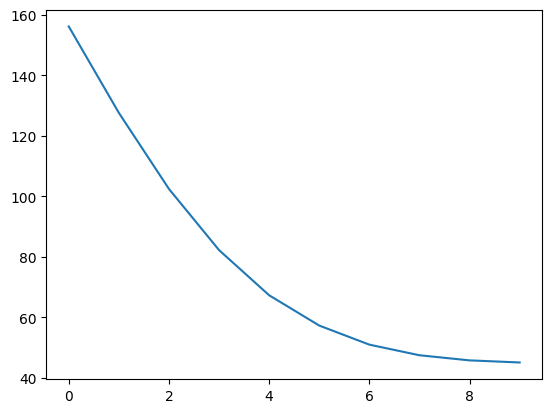

In [33]:
plt.plot(train_loss)

In [34]:
eval(model, test_dl, loss_module, device)

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_34/1577062175.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(target)


44.794462355356366

/tmp/ipykernel_34/1577062175.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(target)


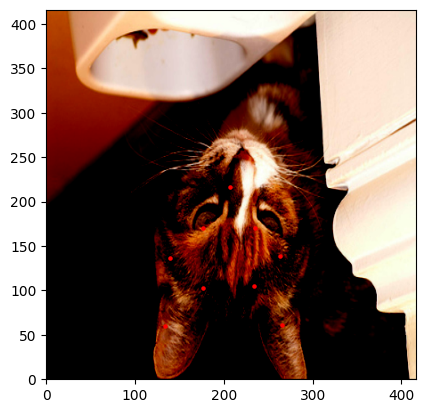

In [35]:
img, trg = test_ds[400]
tr = trg.numpy()
pr_targt = model(img.to(device).to(torch.float32).unsqueeze(0)).clone().detach().to("cpu").squeeze(0)
# pr_targt = norml_to_trg(pr_targt, mean, std)
im = img.permute((1,2,0)).numpy()
plot_image(im, pr_targt[0])